In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../input/autism-image-data/AutismDataset"))

['consolidated', 'valid', 'test', 'train']


In [2]:
import keras,os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
import numpy as np
from tensorflow.keras.applications import VGG16
from keras.models import Model
from tensorflow.keras import optimizers , layers, applications


In [3]:
filenames = os.listdir("../input/autism-image-data/AutismDataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:
test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test")
categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'Autistic':
        categories.append(str(1))
    else:
        categories.append(str(0))

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': categories
})

In [5]:
image_size = 224
input_shape = (image_size, image_size, 3)
#Hyperparameters
epochs = 40
batch_size = 32

In [6]:
# Prepare Test and Train Data
train_df, validate_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0] #2286
total_validate = validate_df.shape[0] #254

In [7]:
# Training Generator
from keras.preprocessing.image import ImageDataGenerator, load_img

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../input/autism-image-data/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2286 validated image filenames belonging to 2 classes.


In [8]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "../input/autism-image-data/AutismDataset/train/",
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 254 validated image filenames belonging to 2 classes.


In [9]:
#Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "../input/autism-image-data/AutismDataset/test/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 300 validated image filenames.


In [10]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=True, weights="imagenet")

553467904/553467096 [==============================] - 18s 0us/step


In [11]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# last_layer = pre_trained_model.get_layer('block5_pool')
# last_output = last_layer.output

# # Flatten the output layer to 1 dimension
# x = GlobalMaxPooling2D()(last_output)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.5
# x = Dropout(0.5)(x)
# # Add a final sigmoid layer for classification
# x = layers.Dense(1, activation='sigmoid')(x)
# model = Model(pre_trained_model.input, x)
# model.summary()

In [12]:
from sklearn import model_selection
model = keras.Sequential()
for layer in pre_trained_model.layers[:-4]:
    model.add(layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
#Freezing
from keras import models
for layer in model.layers:
  layer.trainable = False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [15]:
model.add(GlobalMaxPooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [50]:
#from keras.callbacks import ModelCheckpoint, EarlyStopping
#checkpoint = ModelCheckpoint("/content/drive/MyDrive/AutismDataset/autismvgg.h5", monitor='val_accuracy',
 #                            verbose=1, save_best_only=True,
  #                           save_weights_only=False, mode='auto', save_freq=1)
#early = EarlyStopping(monitor='val_accuracy', patience=3, verbose=2, mode='auto')

In [17]:
#Fit Model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

Epoch 1/40
71/71 [==============================] - 636s 9s/step - loss: 0.7514 - accuracy: 0.5475 - val_loss: 0.6081 - val_accuracy: 0.6920
Epoch 2/40
71/71 [==============================] - 603s 8s/step - loss: 0.6578 - accuracy: 0.6304 - val_loss: 0.5823 - val_accuracy: 0.6920
Epoch 3/40
71/71 [==============================] - 617s 9s/step - loss: 0.6147 - accuracy: 0.6610 - val_loss: 0.5741 - val_accuracy: 0.6920
Epoch 4/40
71/71 [==============================] - 618s 9s/step - loss: 0.5924 - accuracy: 0.6837 - val_loss: 0.5591 - val_accuracy: 0.7143
Epoch 5/40
71/71 [==============================] - 605s 9s/step - loss: 0.5805 - accuracy: 0.6965 - val_loss: 0.5580 - val_accuracy: 0.6920
Epoch 6/40
71/71 [==============================] - 589s 8s/step - loss: 0.6019 - accuracy: 0.6797 - val_loss: 0.5525 - val_accuracy: 0.7143
Epoch 7/40
71/71 [==============================] - 574s 8s/step - loss: 0.5875 - accuracy: 0.6801 - val_loss: 0.5518 - val_accuracy: 0.7277
Epoch 8/40
71

In [18]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.803571  ;  loss = 0.453303 


Text(0.5, 1.0, 'Training and Validation Accuracy')

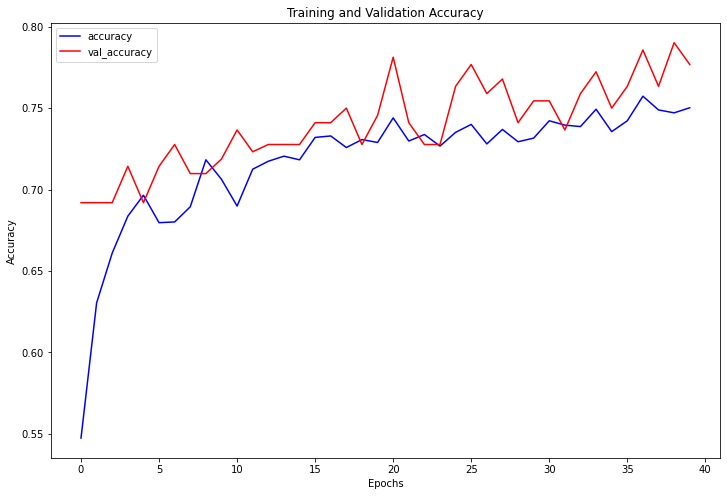

In [19]:
# Plot train and validation accuracy
import seaborn as sns
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["accuracy", "val_accuracy"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

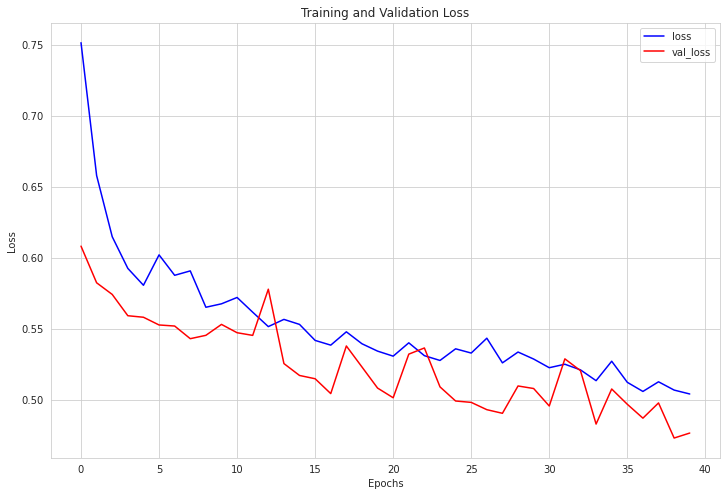

In [20]:
# Plot train and validation loss
plt.figure(figsize=(12, 8))
sns.lineplot(data=history_df.loc[:, ["loss", "val_loss"]], palette=['b', 'r'], dashes=False)
sns.set_style("whitegrid")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [21]:
#from keras.models import load_model
model.save('40epochs.h5')

In [22]:
#Prepare Testing
test_filenames = os.listdir("../input/autism-image-data/AutismDataset/test/")
test_df = pd.DataFrame({


    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [23]:
# Predict
threshold = 0.5
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

1
1
0
0
0
1
0
1
1


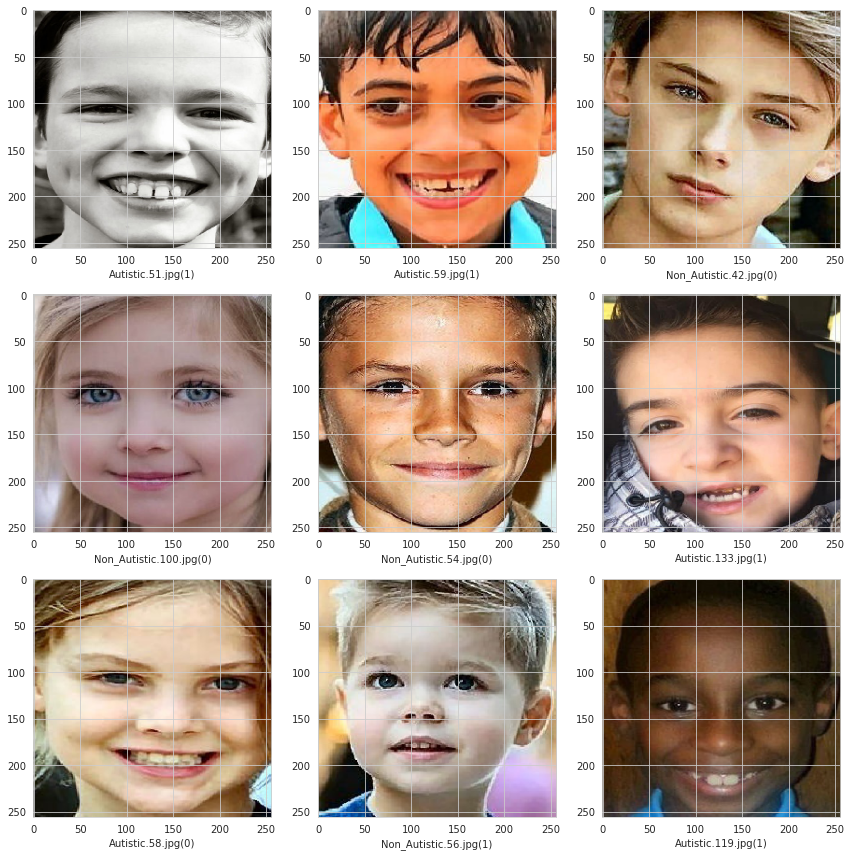

In [28]:
#See Predicted Result
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../input/autism-image-data/AutismDataset/test/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
    print(category)
plt.tight_layout()
plt.show()

4.97806e-10
[[4.97806e-10]]
Non_Autistic child
_____________________
[[0.]]
Non-Autistic child



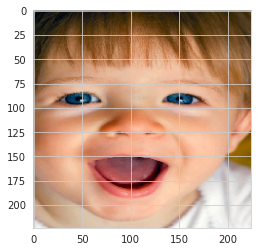

In [26]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
img = image.load_img("../input/autism-image-data/AutismDataset/test/Autistic.22.jpg",target_size=(224,224))
# img = image.load_img("/content/drive/MyDrive/imgtest.jpg",target_size=(224,224))
#img = image.load_img("/content/drive/MyDrive/non.jpg",target_size=(224,224))
#img = image.load_img("/content/drive/MyDrive/images/6.jpg",target_size=(224,224))
#img = image.load_img("/content/drive/MyDrive/AutismDataset/test/Non_Autistic.144.jpg",target_size=(224,224))
#img = image.load_img("/content/drive/MyDrive/9.jpg",target_size=(224,224))


img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)
from keras.models import load_model
saved_model = load_model('/kaggle/working/40epochs.h5')
output = saved_model.predict(img)
print(output[0][0])
print(output)
if output > 0.5:
  print("Autistic child")
else:
  print("Non_Autistic child")
print("_____________________")
print(np.round(output))
if np.round(output)>0.5:
  print("Autistic child\n")
else:
    print("Non-Autistic child\n")


#if softmax
#if output[0][0] > output[0][1]:
  #  print("autistic")
#else:
 #    print('Non_autistic')